In [1]:
from tops.config import instantiate, LazyConfig
from ssd import utils
from tqdm import tqdm
import numpy as np
import pandas as pd
from math import ceil

In [4]:
def get_config(config_path):
    cfg = LazyConfig.load(config_path)
    cfg.train.batch_size = 1
    return cfg


In [5]:
def get_dataloader(cfg, dataset_to_visualize):
    if dataset_to_visualize == "train":
        # Remove GroundTruthBoxesToAnchors transform
        cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
        data_loader = instantiate(cfg.data_train.dataloader)
    else:
        cfg.data_val.dataloader.collate_fn = utils.batch_collate
        data_loader = instantiate(cfg.data_val.dataloader)

    return data_loader

In [6]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def analyze_something(dataloader, cfg):
    label_count = Counter()
    dataset = pd.DataFrame(columns=['image_id','labels','boxes'])
    for batch in tqdm(dataloader):
        # Remove the two lines below and start analyzing :D
        labels = batch['labels'].tolist()
        boxes = batch['boxes'].tolist()
        image_id = batch['image_id'].tolist()
        dataset = dataset.append({'image_id': image_id[0], 'labels':labels[0],'boxes': boxes[0]},ignore_index=True)
        '''for labels in batch['labels']:
            label_count.update(labels.numpy())'''
    dataset.to_csv("dataset.csv")       
    print("Item counts "+str(label_count))

In [7]:

def main():
    config_path = "configs/tdt4265.py"
    cfg = get_config(config_path)
    dataset_to_analyze = "train"  # or "val"

    print("Label map is:", cfg.label_map)
    print(cfg.data_train)
    dataloader = get_dataloader(cfg, dataset_to_analyze)
    analyze_something(dataloader, cfg)
    
main()

NameError: name 'LazyConfig' is not defined

In [2]:
import ast
data = pd.read_csv('dataset.csv',index_col=0)
data.boxes= data.boxes.apply(ast.literal_eval)
data.labels = data.labels.apply(ast.literal_eval)

In [3]:
data

,image_id,labels,boxes
0,1340,"[8, 7, 7, 1, 7, 7]","[[0.016689453274011612, 0.49460938572883606, 0..."
1,124,"[1, 8, 5, 7, 7, 7, 7, 7]","[[0.0361328125, 0.6796875, 0.08369140326976776..."
2,571,"[1, 1, 1, 7, 1, 1, 1, 1, 1, 7, 7, 1, 7, 1]","[[0.46668946743011475, 0.48570311069488525, 0...."
3,87,"[1, 1, 7, 7, 7, 6, 6, 5]","[[0.38203126192092896, 0.658984363079071, 0.43..."
4,1003,"[3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 1, 1, ...","[[0.017695313319563866, 0.4144531190395355, 0...."
...,...,...,...
1599,23,"[7, 7, 5, 1, 1, 7, 7, 7, 6, 6]","[[0.3889453113079071, 0.6035937666893005, 0.39..."
1600,1378,"[7, 7, 7, 7]","[[0.9756835699081421, 0.4483593702316284, 0.97..."
1601,1049,"[1, 1, 1, 1, 1, 1, 2, 1, 7]","[[0.04559570178389549, 0.6187499761581421, 0.1..."
1602,1583,"[7, 7, 7, 7, 7, 7, 7, 6]","[[0.9742285013198853, 0.541796863079071, 0.979..."


In [4]:
data.sort_values(by=['image_id']).image_id

817        1
545        2
286        3
797        4
1074       5
        ... 
565     1600
934     1601
669     1602
1269    1603
878     1604
Name: image_id, Length: 1604, dtype: int64

In [5]:
box_list = []
label_list = []
for boxes,labels in zip(data.boxes,data.labels):
    box_list = box_list + boxes
    label_list = label_list + labels
boxes = pd.DataFrame(columns=['box','label','box_px','height','width','size','cluster'])
boxes.box=box_list
boxes.label=label_list

In [6]:
def box_to_pixels(box):
    return [int(box[0]*1024),int(box[1]*128),int(box[2]*1024),int(box[3]*128)]

def box_size(box):
    return (box[0]-box[2])*(box[1]-box[3])

def box_height(box):
    return (box[3]-box[1])
def box_width(box):
    return (box[2]-box[0])

def category(int):
    tags = {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}
    return tags[int]

In [7]:
boxes.box_px = boxes.box.apply(box_to_pixels)
boxes.height = boxes.box_px.apply(box_height)
boxes.width = boxes.box_px.apply(box_width)
boxes.size = boxes.box_px.apply(box_size)

In [8]:
boxes['category'] = boxes.label.apply(category)

In [9]:
boxes.category.value_counts()

car        9563
person     4910
rider      1588
bicycle    1043
scooter     615
bus         445
truck       123
Name: category, dtype: int64

In [10]:
for i in boxes.category.unique():
    print(i)
    print(boxes[boxes['category']==i].describe())

rider
        label       height        width         size
count  1588.0  1588.000000  1588.000000  1588.000000
mean      8.0    28.753778     8.445214   300.515743
std       0.0    15.268707     4.995665   353.385756
min       8.0     8.000000     2.000000    20.000000
25%       8.0    16.000000     5.750000    91.000000
50%       8.0    25.000000     7.000000   174.000000
75%       8.0    40.000000     9.000000   360.000000
max       8.0    91.000000    47.000000  4277.000000
person
        label       height        width         size
count  4910.0  4910.000000  4910.000000  4910.000000
mean      7.0    26.766191     7.135438   246.185336
std       0.0    15.458495     4.124734   288.280558
min       7.0     8.000000     2.000000    16.000000
25%       7.0    14.000000     4.000000    64.000000
50%       7.0    21.000000     6.000000   132.000000
75%       7.0    37.000000     9.000000   312.000000
max       7.0    84.000000    31.000000  2573.000000
car
        label       height   

In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(np.array([boxes.height,boxes.width]).T)
boxes.cluster = kmeans.predict(np.array([boxes.height,boxes.width]).T)

In [37]:
from sklearn.cluster import AgglomerativeClustering
boxes.cluster = AgglomerativeClustering(linkage='ward',n_clusters=6).fit_predict(np.array([boxes.height,boxes.width]).T)

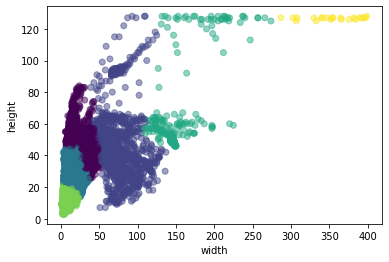

In [38]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(boxes.width, boxes.height, c=boxes.cluster, alpha=0.5)
plt.xlabel('width')
plt.ylabel('height')
plt.show()

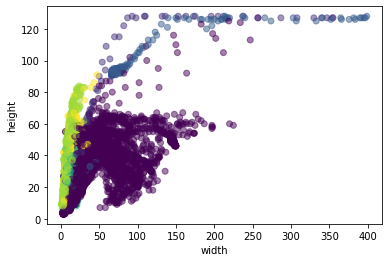

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(boxes.width, boxes.height, c=boxes.label, alpha=0.5)
plt.xlabel('width')
plt.ylabel('height')
plt.show()

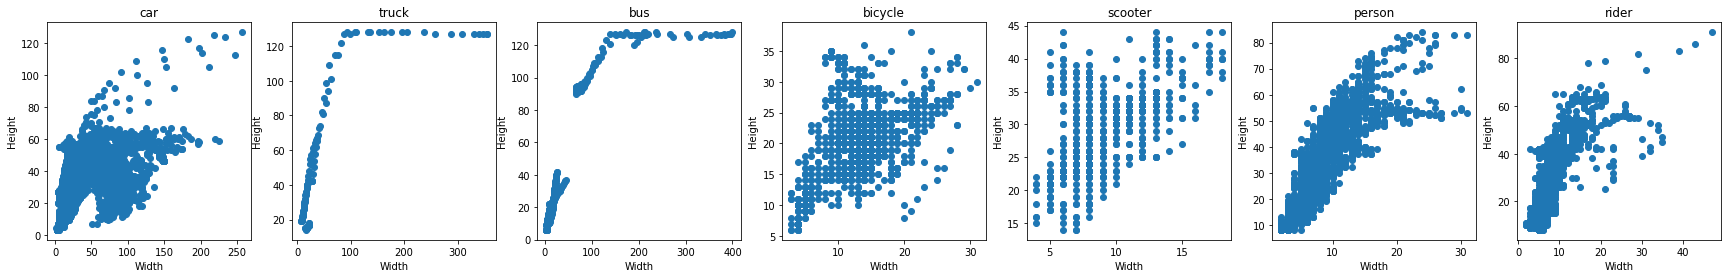

In [40]:
fig, axs = plt.subplots(1,7, figsize=[30,4])
tags = {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}
for i,label in enumerate(np.sort(boxes.label.unique())):
    label_boxes = boxes[boxes.label == label]
    
    axs[i].scatter(label_boxes.width,label_boxes.height)
    axs[i].set_title(str(tags[label]),fontsize=12)
    axs[i].set_xlabel("Width")
    axs[i].set_ylabel("Height")

plt.show()


In [41]:
new_anchors = []
for cluster in np.sort(boxes.cluster.unique()):
    
    cluster_boxes = boxes[boxes.cluster == cluster]
    new_anchors.append([ceil(cluster_boxes['height'].quantile(q=0.95)),ceil(cluster_boxes['width'].quantile(q=0.95))])

In [42]:
sorted(new_anchors, key=lambda x : x[0]*x[1])

[[20, 19], [41, 27], [62, 44], [92, 115], [128, 220], [127, 397]]

In [43]:
new_anchors2 = []
for label in np.sort(boxes.label.unique()):
    
    label_boxes = boxes[boxes.label == label]
    new_anchors2.append([ceil(label_boxes['height'].quantile(q=0.95)),ceil(label_boxes['width'].quantile(q=0.95))])

In [44]:
sorted(new_anchors2, key=lambda x : x[0]*x[1])

[[40, 15], [31, 24], [55, 15], [56, 18], [54, 85], [126, 215], [128, 284]]